In [90]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from softce_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

In [91]:
from softce_validation.tasks.available_tasks import get_available_tasks

tasks = get_available_tasks()

# For plotting reasons, we do eight schools first
tasks = {"eight_schools": tasks.pop("eight_schools"), **tasks}

In [92]:
method_names = [
    "SoftCE",
    "ELBO",
    ]

colors = {
    "SoftCE": "tab:orange",
    "ELBO": "tab:blue",
}

metric_names = [
    "mean_log_prob_reference",
    "negative_posterior_mean_l2",
    "coverage_probabilities",
]

results = {task_name: {method_name: [] for method_name in method_names} for task_name in tasks.keys()}


for task_name in tasks.keys():
    for method_name in method_names:
        files = [f for f in os.listdir(f"results/{task_name}") if method_name in f]
        for file in files:
            results[task_name][method_name].append(dict(np.load(f"results/{task_name}/{file}")))

for task_name in tasks.keys():
    for method_name in method_names:
        results[task_name][method_name] = {
            metric_name: np.stack([run[metric_name] for run in results[task_name][method_name] if "negative_posterior_mean_l2" in run.keys()]) for metric_name in metric_names
        } # TODO simplify
            

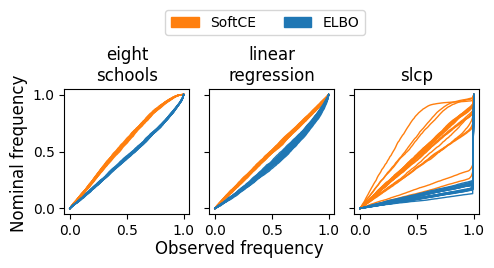

In [93]:
# Coverage first...
fig, axes = plt.subplots(ncols=len(tasks), sharey=True)
nominal_frequency = np.linspace(0, 1, 100)

# Now we have the legend we can add the run-level coverage
for (task_name, task_result), ax in zip(results.items(), axes, strict=False):
    for method_name in method_names:
        coverage_probs = task_result[method_name]["coverage_probabilities"]

        ax.plot(
            nominal_frequency,
            coverage_probs.T,
            color=colors[method_name],
            linewidth=1,
            )
        ax.set_box_aspect(1)
        ax.set_title(task_name.replace("_", "\n"))


handles = [mpatches.Patch(color=v, label=k) for k, v in colors.items()]
fig.legend(
    handles=handles,
    bbox_to_anchor=[0.55, 1.05],
    loc='upper center',
    ncol=len(method_names),
    )
fig.supxlabel("Observed frequency", y=0.2)
fig.supylabel("Nominal frequency", y=0.55, x=0.05)
fig.set_size_inches(5.1, 3)
fig.tight_layout()
fig.savefig("plots/coverage.pdf", bbox_inches="tight")

/tmp/ipykernel_59175/2878365709.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


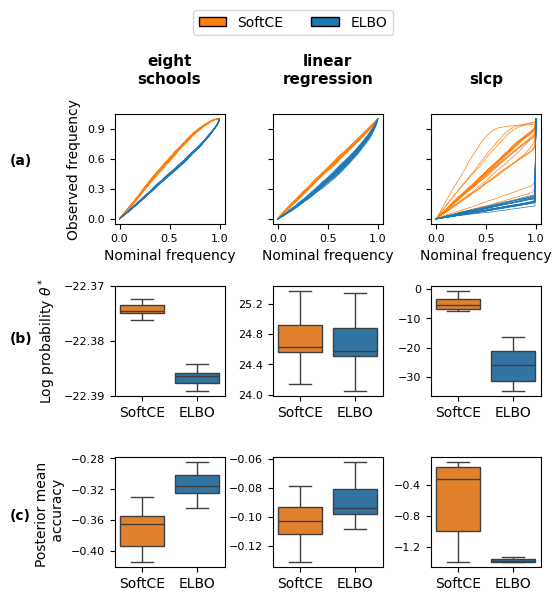

In [189]:
####### Coverage #######
fig = plt.figure(layout='constrained', figsize=(7, 5.15))
subfigs = fig.subfigures(nrows=3, ncols=1)

axes0 = subfigs[0].subplots(ncols=len(results), sharey=True)


nominal_frequency = np.linspace(0, 1, 100)

# Now we have the legend we can add the run-level coverage
for (task_name, task_result), ax in zip(results.items(), axes0, strict=False):
    for method_name in method_names:
        coverage_probs = task_result[method_name]["coverage_probabilities"]

        ax.plot(
            nominal_frequency,
            coverage_probs.T,
            color=colors[method_name],
            linewidth=0.5,
            )
        ax.set_title(task_name.replace("_", "\n"), fontsize=11, fontweight="bold", y=1.2)
        ax.set_xlabel("Nominal frequency")

####### log prob true #######

axes1 = subfigs[1].subplots(ncols=len(results))

for task_result, ax in zip(results.values(), axes1, strict=True):
    df = pd.DataFrame(
        {method_name: task_result[method_name]["mean_log_prob_reference"] for method_name in method_names},
    )
    sns.boxplot(df, ax=ax, showfliers=False, palette=colors)

### Negative posterior mean l2 ###
axes2 = subfigs[2].subplots(ncols=len(results))

for task_result, ax in zip(results.values(), axes2, strict=True):
    df = pd.DataFrame(
        {method_name: task_result[method_name]["negative_posterior_mean_l2"] for method_name in method_names},
    )
    sns.boxplot(df, ax=ax, showfliers=False,  palette=colors)
    

axes0[0].set_ylabel("Observed frequency")
axes1[0].set_ylabel(r"Log probability $\theta^*$")
axes2[0].set_ylabel("Posterior mean \n accuracy")


for axes in [axes0, axes1, axes2]:
    for ax in axes:
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='y', which='both', labelsize=8)
        ax.set_box_aspect(1)


for ax in axes0:
    ax.tick_params(axis='x', which='both', labelsize=8)

axes1[0].set_yticks([-22.37, -22.38, -22.39])


handles = [mpatches.Patch(facecolor=v, label=k, edgecolor="black") for k, v in colors.items()]
fig.legend(
    handles=handles,
    bbox_to_anchor=[0.6, 1.03],
    loc='lower center',
    ncol=len(method_names),
    )

letters = {
    "(a)": (-2.4, 0.1),
    "(b)": (-2.4, -0.13),
    "(c)": (-2.4, -0.36),
}

for letter, position in letters.items():
    axes[0].annotate(letter, xy=position, annotation_clip=False, fontweight="bold")

plt.tight_layout()
plt.subplots_adjust(top=0.67, wspace=0.1)
plt.savefig("plots/metrics.pdf", bbox_inches="tight")



### Run times

In [182]:
run_times = {task_name: [] for task_name in tasks.keys()}

for task_name in tasks.keys():
    files = [f for f in os.listdir(f"results/{task_name}/") if "run_times" in f]
    for file in files:
        run_times[task_name].append(dict(np.load(f"results/{task_name}/{file}")))

run_times_dict = {task_name: {meth: [] for meth in method_names} for task_name in tasks.keys()}

for task_name in tasks.keys():
    for method_name in method_names:
        run_times_dict[task_name][method_name] = np.stack([run[method_name].item() for run in run_times[task_name]])

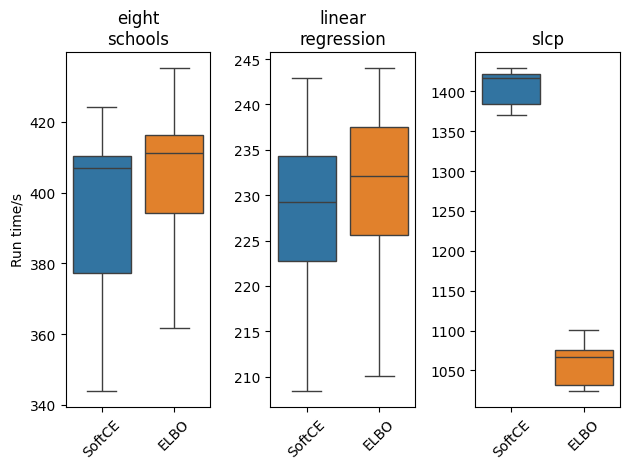

In [186]:
fig, axes = plt.subplots(ncols=len(tasks))

for (task_name, times), ax in zip(run_times_dict.items(), axes, strict=True):
    df = pd.DataFrame(times)
    sns.boxplot(df, ax=ax, showfliers=False)
    ax.set_title(task_name.replace("_", "\n")) 
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel("Run time/s")
fig.tight_layout()
